<a href="https://colab.research.google.com/github/Soufianelotfi-lab/MLIP_SOUFIANE_THOMAS/blob/main/Classification_planet_(SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**`1. Importer les dependances`**



- Cette section regroupe l’ensemble des bibliothèques nécessaires à la lecture et au prétraitement des images, à l’extraction des caractéristiques (HOG, LBP), ainsi qu’à l’entraînement et à l’évaluation du modèle de classification.

In [ ]:
!pip install mahotas
import os
import numpy as np
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog, local_binary_pattern
import mahotas

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt


**`2. Importer depuis kaglle`**

- Dans cette étape, nous téléchargeons le jeu de données Planets and Moons depuis Kaggle à l’aide de la bibliothèque kagglehub.
Le dataset est ensuite stocké localement dans l’environnement d’exécution, ce qui nous permet de l’utiliser pour les étapes suivantes, notamment l’exploration des données, le prétraitement des images et l’entraînement du modèle de classification.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("emirhanai/planets-and-moons-dataset-ai-in-space")
print("Dataset téléchargé ici :", path)



Using Colab cache for faster access to the 'planets-and-moons-dataset-ai-in-space' dataset.
Dataset téléchargé ici : /kaggle/input/planets-and-moons-dataset-ai-in-space


**`3. Choix des classes`**

- Au départ, le jeu de données contenait 10 classes différentes.
Dans le cadre de notre étude, nous avons choisi de nous concentrer sur 6 classes (Earth, Jupiter, Mars, Neptune, Pluto et Venus)

In [ ]:
selected_classes = ["Earth", "Jupiter","Mars", "Neptune", "Pluto", "Venus"]


**`4. Copier uniquement ces 6 classes vers /content/planets_selected`**

In [ ]:

import os
import shutil

src_base = "/kaggle/input/planets-and-moons-dataset-ai-in-space/Planets_Moons_Data/Planets and Moons"
dst_base = "/content/planets_selected"

os.makedirs(dst_base, exist_ok=True)

for cls in selected_classes:
    src = os.path.join(src_base, cls)
    dst = os.path.join(dst_base, cls)

    if os.path.exists(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
        print(f"Copié : {cls}")
    else:
        print(f"Introuvable : {cls}")


Copié : Earth
Copié : Jupiter
Copié : Mars
Copié : Neptune
Copié : Pluto
Copié : Venus


**`5. Définir les classes + dataset_path`**

In [ ]:
dataset_path = "/content/planets_selected"

classes = ["Earth", "Jupiter", "Mars", "Neptune", "Pluto", "Venus"]

img_size = (128, 128)


- Cette étape permet de vérifier que chaque classe sélectionnée contient bien des images.
Pour cela, nous parcourons les dossiers correspondant à chaque classe et comptons le nombre d’images associées, afin de nous assurer que le dataset est correctement structuré et exploitable pour la suite du traitement.













In [ ]:
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    files = os.listdir(class_path)
    print(f"{cls} → {len(files)} images")


Neptune → 149 images
Pluto → 149 images
Mars → 149 images
Jupiter → 149 images
Earth → 149 images
Venus → 149 images




- Nous chargeons et affichons une image d’exemple de la classe Neptune afin de vérifier le bon chargement des images.



Image chargée avec succès : /content/planets_selected/Neptune/Neptune (80).jpg


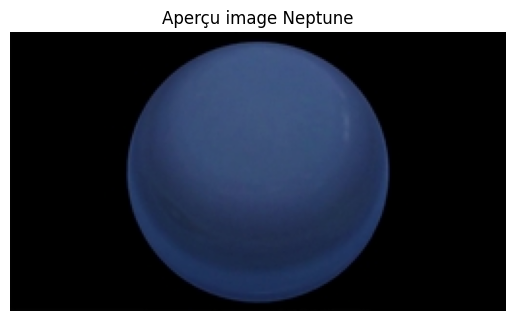

In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt

test_img_path = os.path.join(dataset_path, "Neptune", os.listdir(os.path.join(dataset_path, "Neptune"))[10])
img = imread(test_img_path)

print("Image chargée avec succès :", test_img_path)


plt.imshow(img)
plt.title("Aperçu image Neptune")
plt.axis("off")
plt.show()



**`6. Fonction d’extraction des caractéristiques`**

**`- Pour LBP`**

- Dans cette partie, nous illustrons le principe d’extraction des caractéristiques LBP (Local Binary Pattern) à partir d’une image d’exemple.
L’image est d’abord redimensionnée et convertie en niveaux de gris, puis le descripteur LBP est calculé afin de mettre en évidence les textures locales, qui constituent des informations discriminantes pour la classification.

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


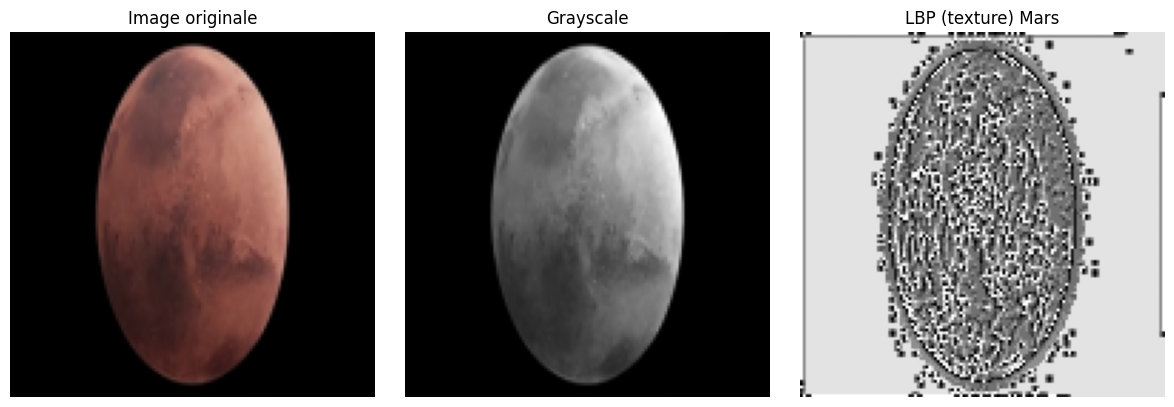

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import local_binary_pattern

# ---- Charger image ----
img_path = os.path.join(dataset_path, "Mars", os.listdir(os.path.join(dataset_path, "Mars"))[10])
img = imread(img_path)
img = resize(img, (128, 128))

# ---- Niveaux de gris ----
img_gray = rgb2gray(img)

# ---- Extraction LBP ----
P = 8   # nombre de points
R = 1   # rayon
lbp = local_binary_pattern(img_gray, P, R, method="uniform")

# ---- Affichage ----
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image originale")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(lbp, cmap="gray")
plt.title("LBP (texture) Mars")
plt.axis("off")

plt.tight_layout()
plt.show()


**`- pour visulaiser HOG`**

- Dans cette partie, nous illustrons l’extraction des caractéristiques HOG (Histogram of Oriented Gradients) à partir d’une image d’exemple.
Après un prétraitement comprenant le redimensionnement et la conversion en niveaux de gris, le descripteur HOG est calculé afin de mettre en évidence les contours et les orientations locales des gradients, qui constituent des informations pertinentes pour la discrimination entre les classes.

Image choisie : /content/planets_selected/Neptune/Neptune (80).jpg


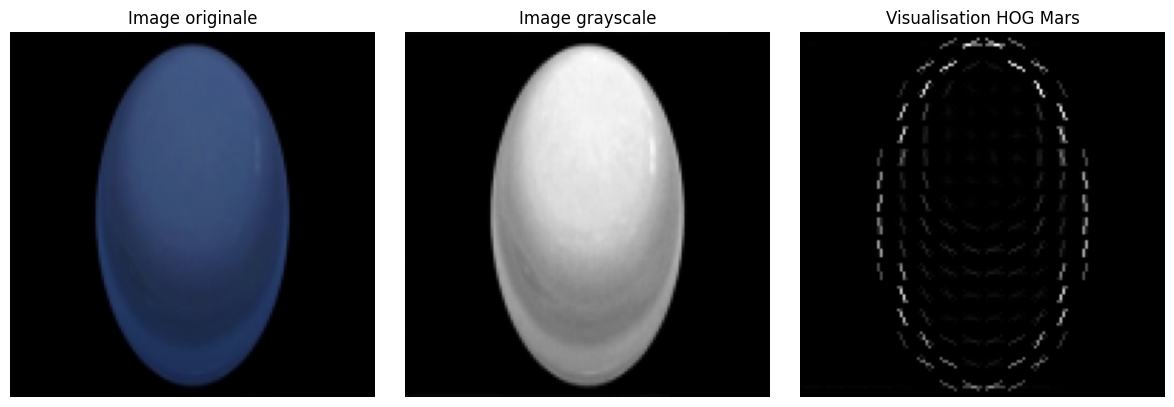

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import os


img_path = os.path.join(dataset_path, "Neptune", os.listdir(os.path.join(dataset_path, "Neptune"))[10])

print("Image choisie :", img_path)

# Prétraitement
img = imread(img_path)
img = resize(img, (128, 128))
img_gray = rgb2gray(img)

# Extraction + visualisation HOG
hog_feat, hog_img = hog(
    img_gray,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    channel_axis=None
)

# Normalisation pour affichage
hog_img = exposure.rescale_intensity(hog_img, in_range=(0, 10))

# Affichage
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Image originale")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_gray, cmap="gray")
plt.title("Image grayscale")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(hog_img, cmap="gray")
plt.title("Visualisation HOG Mars")
plt.axis("off")

plt.tight_layout()
plt.show()


**`- Pour extraire toutes les informations`**

- Dans cette étape, nous définissons une fonction permettant d’extraire, pour l’ensemble du dataset, les descripteurs décrits précédemment.
Pour chaque classe sélectionnée, les images sont lues, redimensionnées et converties en niveaux de gris, puis les descripteurs HOG, LBP et Haralick, présentés dans les sections précédentes, sont calculés.

In [ ]:
def extract_features(path, img_size=(128,128)):
    X = []
    y = []

    for label, cls in enumerate(classes):
        folder = os.path.join(path, cls)
        print(f"Traitement classe : {cls}")

        for img_name in tqdm(os.listdir(folder)):
            img_path = os.path.join(folder, img_name)

            # Lire image
            img = imread(img_path)
            img = resize(img, img_size)

            # Grayscale
            img_gray = rgb2gray(img)

            # --- HOG ---
            hog_feat = hog(
                img_gray,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                channel_axis=None
            )

            # --- LBP ---
            lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
            lbp_hist, _ = np.histogram(lbp, bins=10, range=(0,10))
            lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-6)

            # --- Couleur ---
            r_hist, _ = np.histogram(img[:,:,0], bins=32, range=(0,1))
            g_hist, _ = np.histogram(img[:,:,1], bins=32, range=(0,1))
            b_hist, _ = np.histogram(img[:,:,2], bins=32, range=(0,1))
            color_feat = np.concatenate([r_hist, g_hist, b_hist])
            color_feat = color_feat / (color_feat.sum() + 1e-6)

            # Fusion
            features = np.concatenate([hog_feat, lbp_hist, color_feat]) #il faut changer suivant les caractéristiques que nous voulons extraire
            #features = np.concatenate([color_feat])

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)


**`7. Extraire X et y`**

- Dans cette étape, nous appliquons la fonction d’extraction des caractéristiques décrite précédemment afin de construire les données d’apprentissage.
Nous obtenons ainsi la matrice X, qui regroupe l’ensemble des vecteurs de caractéristiques extraits pour chaque image, ainsi que le vecteur y, contenant les étiquettes associées aux différentes classes.
Les dimensions de X et y sont ensuite affichées afin de vérifier la cohérence des données avant de passer à l’étape suivante.

In [ ]:
X, y = extract_features(dataset_path)
print("Shape X =", X.shape)
print("Shape y =", y.shape)


Traitement classe : Earth


  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.


Traitement classe : Jupiter


  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.


Traitement classe : Mars


  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  1%|▏         | 2/149 [00:00<00:07, 18.92it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to u

Traitement classe : Neptune


  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.


Traitement classe : Pluto


  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.


Traitement classe : Venus


  0%|          | 0/149 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.


Shape X = (894, 8206)
Shape y = (894,)


**`8. Normalisation + Split`**

- Nous séparons les données en ensembles d’apprentissage et de test, puis nous normalisons les caractéristiques avant l’entraînement du modèle.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- 1) Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2) Normalisation ---
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


print("Taille X_train après PCA :", X_train_s.shape)
print("Taille X_test après PCA :", X_test_s.shape)


Taille X_train après PCA : (715, 8206)
Taille X_test après PCA : (179, 8206)


- Dans cette étape, nous utilisons l’Analyse en Composantes Principales (PCA) afin d’étudier la quantité d’information expliquée par les différentes composantes principales.
En traçant la variance cumulée expliquée, nous pouvons déterminer le nombre minimal de composantes nécessaires pour conserver l’essentiel de l’information tout en réduisant la dimension de l’espace des caractéristiques.

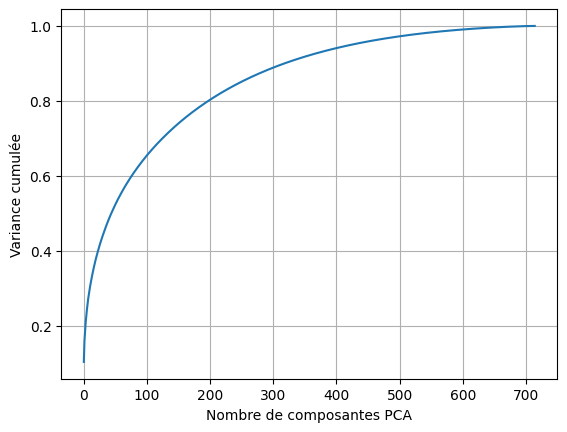

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_s)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Nombre de composantes PCA")
plt.ylabel("Variance cumulée")
plt.grid(True)
plt.show()


In [ ]:
pca = PCA(n_components=715)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

**`9. Entraîner le SVM`**

- Dans cette configuration, nous avons entraîné un classifieur SVM en utilisant la combinaison des trois types de descripteurs : HOG, LBP et RGB (Haralick).
Les résultats obtenus montrent une précision d’environ 90 % sur l’ensemble de test, ce qui indique une bonne capacité de généralisation du modèle lorsque plusieurs sources d’information sont combinées.

- En revanche, lorsque nous utilisons uniquement les caractéristiques issues des images RGB, en modifiant la fonction d’extraction afin de ne conserver que ces descripteurs, le modèle atteint une précision de 100 % sur l’ensemble d’entraînement.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- 4) Entraînement ---
svm = SVC(kernel="rbf", C=10, gamma="scale")
svm.fit(X_train_pca, y_train)

# --- 5) Accuracy d'entraînement ---
y_pred_train = svm.predict(X_train_pca)
acc_train = accuracy_score(y_train, y_pred_train)

# --- 6) Accuracy de test ---
y_pred_test = svm.predict(X_test_pca)
acc_test = accuracy_score(y_test, y_pred_test)

print("Accuracy train :", acc_train)
print("Accuracy test :", acc_test)


Accuracy train : 1.0
Accuracy test : 0.9553072625698324


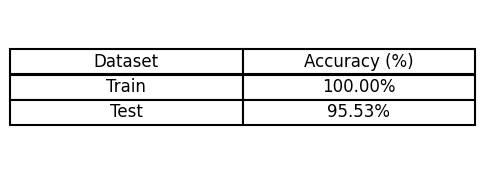

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Conversion en pourcentage
acc_train_pct = acc_train * 100
acc_test_pct = acc_test * 100

# Tableau sous forme DataFrame
results = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Accuracy (%)": [f"{acc_train_pct:.2f}%", f"{acc_test_pct:.2f}%"]
})

fig, ax = plt.subplots(figsize=(6, 2))

ax.axis('off')

table = ax.table(
    cellText=results.values,
    colLabels=results.columns,
    loc='center',
    cellLoc='center'
)

# Style du tableau
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

# Bordures noires
for key, cell in table.get_celld().items():
    cell.set_edgecolor("black")
    cell.set_linewidth(1.5)

plt.show()


**`10. Matrice de confusion`**

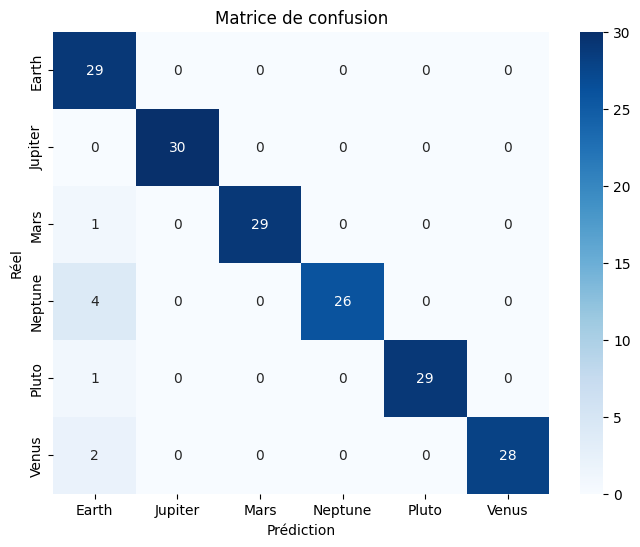

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


**`11. Déterminer la precission et la recall`**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=classes))


              precision    recall  f1-score   support

       Earth       0.78      1.00      0.88        29
     Jupiter       1.00      1.00      1.00        30
        Mars       1.00      0.97      0.98        30
     Neptune       1.00      0.87      0.93        30
       Pluto       1.00      0.97      0.98        30
       Venus       1.00      0.93      0.97        30

    accuracy                           0.96       179
   macro avg       0.96      0.96      0.96       179
weighted avg       0.96      0.96      0.96       179



**`12. Résumé sous tableau`**

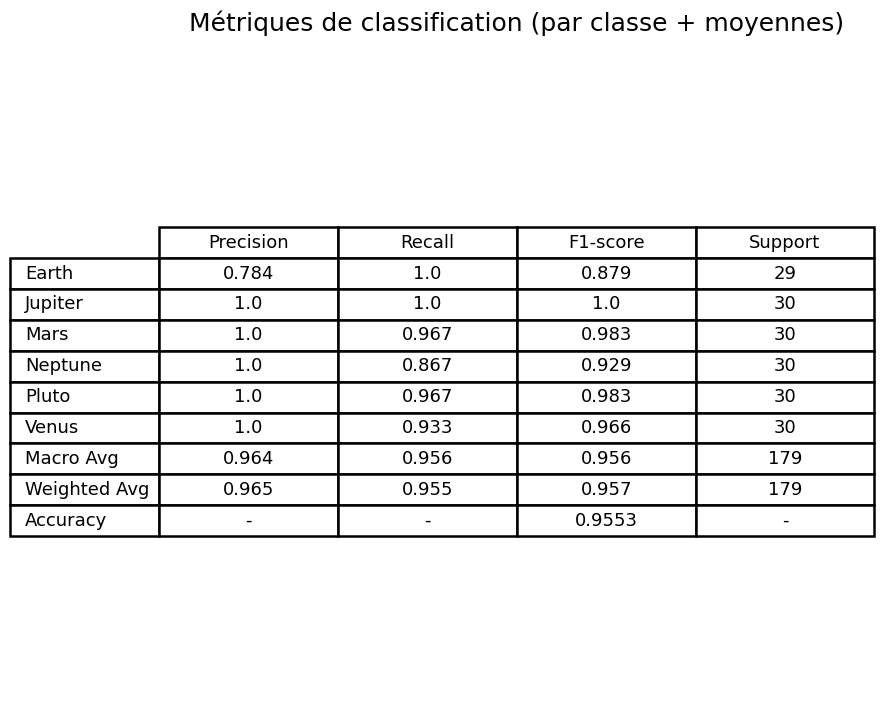

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Générer le rapport
report = classification_report(y_test, y_pred_test, target_names=classes, output_dict=True)

# ---- Construire les lignes ----
table_data = []

# Classes
for cls in classes:
    table_data.append([
        round(report[cls]["precision"], 3),
        round(report[cls]["recall"], 3),
        round(report[cls]["f1-score"], 3),
        int(report[cls]["support"])
    ])

# Moyennes
table_data.append([
    round(report["macro avg"]["precision"], 3),
    round(report["macro avg"]["recall"], 3),
    round(report["macro avg"]["f1-score"], 3),
    int(report["macro avg"]["support"])
])

table_data.append([
    round(report["weighted avg"]["precision"], 3),
    round(report["weighted avg"]["recall"], 3),
    round(report["weighted avg"]["f1-score"], 3),
    int(report["weighted avg"]["support"])
])

# Accuracy seule
table_data.append([
    "-",
    "-",
    round(report["accuracy"], 4),
    "-"
])

row_labels = list(classes) + ["Macro Avg", "Weighted Avg", "Accuracy"]

# ---- AFFICHAGE PRO ----
fig, ax = plt.subplots(figsize=(10, 5 + len(row_labels)*0.25))

ax.axis("off")

table = ax.table(
    cellText=table_data,
    colLabels=["Precision", "Recall", "F1-score", "Support"],
    rowLabels=row_labels,
    loc="center",
    cellLoc="center"
)

# Taille et style
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1.4, 1.6)

# Bordures plus visibles
for key, cell in table.get_celld().items():
    cell.set_linewidth(1.8)
    cell.set_edgecolor("black")

plt.title("Métriques de classification (par classe + moyennes)", fontsize=18, pad=20)
plt.tight_layout()
plt.show()


**`13. Fonction pour prédire une planete`**

In [ ]:
def predict_single_image(img_path):
    # Charger l'image
    img = imread(img_path)
    img_resized = resize(img, img_size)
    img_gray = rgb2gray(img_resized)

    # --- HOG ---
    hog_feat = hog(
        img_gray,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        channel_axis=None
    )

    # --- LBP ---
    lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=10, range=(0,10))
    lbp_hist = lbp_hist / (lbp_hist.sum() + 1e-6)

    # --- Haralick ---
    haralick_feat = mahotas.features.haralick((img_gray*255).astype("uint8")).mean(axis=0)

    # --- Couleur ---
    r_hist, _ = np.histogram(img_resized[:,:,0], bins=32, range=(0,1))
    g_hist, _ = np.histogram(img_resized[:,:,1], bins=32, range=(0,1))
    b_hist, _ = np.histogram(img_resized[:,:,2], bins=32, range=(0,1))
    color_feat = np.concatenate([r_hist, g_hist, b_hist])
    color_feat = color_feat / (color_feat.sum() + 1e-6)

    # Fusion
    feat = np.concatenate([hog_feat, lbp_hist, haralick_feat, color_feat])

    # Normaliser avec TON scaler
    feat_scaled = scaler.transform([feat])

    # Prédiction avec TON modèle SVM
    pred = svm.predict(feat_scaled)[0]
    pred_class = classes[pred]

    # Affichage
    plt.imshow(img)
    plt.title(f"Classe prédite : {pred_class}")
    plt.axis("off")
    plt.show()

    print("Classe prédite :", pred_class)




*   Savoir les chemins des data planets






In [ ]:
!ls /content/planets_selected/Neptune


'Neptune (100).jpg'  'Neptune (146).jpg'  'Neptune (56).jpg'
'Neptune (101).jpg'  'Neptune (147).jpg'  'Neptune (57).jpg'
'Neptune (102).jpg'  'Neptune (148).jpg'  'Neptune (58).jpg'
'Neptune (103).jpg'  'Neptune (149).jpg'  'Neptune (59).jpg'
'Neptune (104).jpg'  'Neptune (14).jpg'   'Neptune (5).jpg'
'Neptune (105).jpg'  'Neptune (15).jpg'   'Neptune (60).jpg'
'Neptune (106).jpg'  'Neptune (16).jpg'   'Neptune (61).jpg'
'Neptune (107).jpg'  'Neptune (17).jpg'   'Neptune (62).jpg'
'Neptune (108).jpg'  'Neptune (18).jpg'   'Neptune (63).jpg'
'Neptune (109).jpg'  'Neptune (19).jpg'   'Neptune (64).jpg'
'Neptune (10).jpg'   'Neptune (1).jpg'	  'Neptune (65).jpg'
'Neptune (110).jpg'  'Neptune (20).jpg'   'Neptune (66).jpg'
'Neptune (111).jpg'  'Neptune (21).jpg'   'Neptune (67).jpg'
'Neptune (112).jpg'  'Neptune (22).jpg'   'Neptune (68).jpg'
'Neptune (113).jpg'  'Neptune (23).jpg'   'Neptune (69).jpg'
'Neptune (114).jpg'  'Neptune (24).jpg'   'Neptune (6).jpg'
'Neptune (115).jpg'  'Neptu



*   Faire la prediction sur une seule



/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


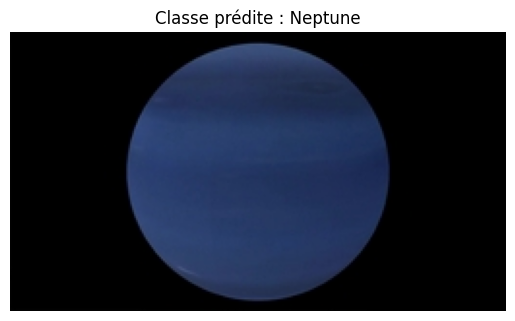

✔ Classe prédite : Neptune


In [ ]:
predict_single_image("/content/planets_selected/Neptune/Neptune (14).jpg")
